# First look at the data

In [152]:
# Remove this for debugging
import warnings
warnings.filterwarnings("ignore")

# Loading the Packages needed.
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mne
import pandas as pd
import io_utils as iu
from importlib import reload

# Loading sklearn packages
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy

reload(iu)

%matplotlib inline

# The Text Data

In [2]:
words, onsets, offsets, _ = iu.load_text()

In [3]:
word_keys, word_counts = iu.word_histogram(words)

There are 1508 unique words and 5459 words in total.
Common words take up 526 which is about 9.6% of the data


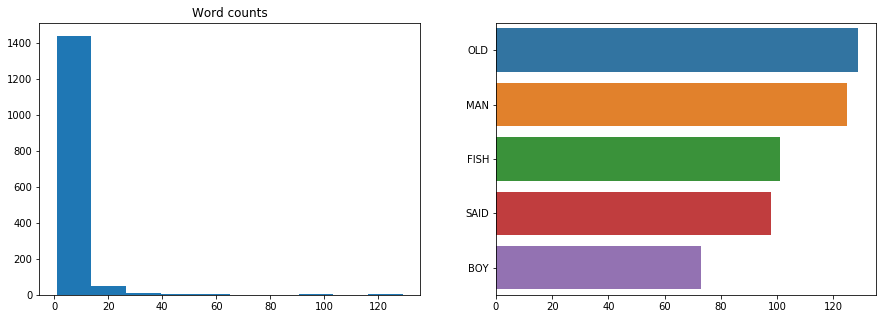

In [125]:
wc_threshold =  60
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(word_counts)
ax[0].set_title('Word counts')
sns.barplot(x=word_counts[word_counts > wc_threshold], y=word_keys[word_counts>wc_threshold], ax=ax[1]);
print(f'There are {len(word_keys)} unique words and {sum(word_counts)} words in total.'
      +f'\nCommon words take up {sum(word_counts[word_counts > wc_threshold])} which is about'
      +f'{(sum(word_counts[word_counts > wc_threshold])/ sum(word_counts))*100:4.1f}% of the data')

Most words only occur one time, which is not the best thing. 

In [96]:
# Getting the words and onsets for each run
word_samples_ons = iu.words_to_onsets(onsets, words, word_counts, word_keys, wc_threshold=wc_threshold)
word_samples_ofs = iu.words_to_onsets(offsets, words, word_counts, word_keys, wc_threshold=wc_threshold)

Let's have a quick look at the maximal duration of the words to get a better feeling of how long a time window could be for our further prediction.

In [132]:
word_dur_mean = np.mean(iu.word_dict_summary(word_samples_ons, word_samples_ofs, np.mean))
word_dur_max = np.max(iu.word_dict_summary(word_samples_ons, word_samples_ofs, np.max))
    
print(f'The longest period between onset and off-set of a word is {word_dur_max:4.2f} samples. Which is {word_dur_max/128:4.2f}s')
print(f'The average period between onset and off-set of a word is {word_dur_mean:4.2f} samples. Which is {word_dur_mean/128:4.2f}s')

The longest period between onset and off-set of a word is 79.00 samples. Which is 0.62s
The average period between onset and off-set of a word is 31.69 samples. Which is 0.25s


Even using simple classification of words (i.e. multiclass) will be quite hard. Similarly looking at epoching the data to max periods will only be the first step. 
But we can now epoch data based on the ``word_samples_ons`` dictionary. The onsets for each run and for each target word are in there. 

# The EEG data
## Getting data in shape
At first we are experimenting with a single participant. We are loading the data for each run, do simple preprocessing (average reference, filter). 
We are also extracting the timebins around each word onset.

In [133]:
# A single data set:
participant = 'Subject1'
eeg, mastoids = iu.load_one_subject(participant)

Preprocessing is absolutely necessary. Let's have a look at a single channel in the EEG signal. 

## Simple preprocessing and it's effects

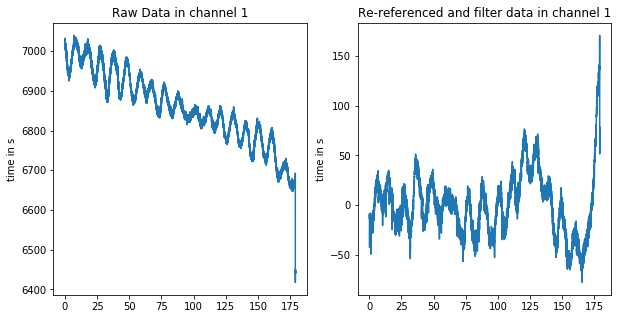

In [203]:
# Create a vector indicating the seconds of the EEG signal:
t = np.linspace(0, eeg[0].shape[0]/128, eeg[0].shape[0])
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(t, eeg[0][:, 0]);
plt.title('Raw Data in channel 1');
plt.ylabel('time in s');
plt.subplot(122)
plt.plot(t, iu.simple_EEG_preprocessing(eeg[0], 0.01, 35, 128)[:, 0])
plt.title('Re-referenced and filter data in channel 1');
plt.ylabel('time in s');

The data is still very noisy, but let's give it a quick trial. 
## Extracting the data

In [334]:
# Preprocessing data for each run of the participant and extracting data based on the word onsets
samples = []
labels = []
runs = []
for n, data in enumerate(eeg):
    eeg_preproc = iu.simple_EEG_preprocessing(data, 1, 35, 128)
    sam, la = iu.get_data_for_word(eeg_preproc, word_samples_ons, idx=n, time_win=32)
    samples.append(np.stack(sam))
    runs.append(n + np.zeros(len(sam)))
    labels.append(np.stack(la))

samples = np.concatenate(samples, 0)
labels = np.hstack(labels)
runs = np.hstack(runs)

## Looking at samples

Text(0.5, 0.98, 'Channel Averages')

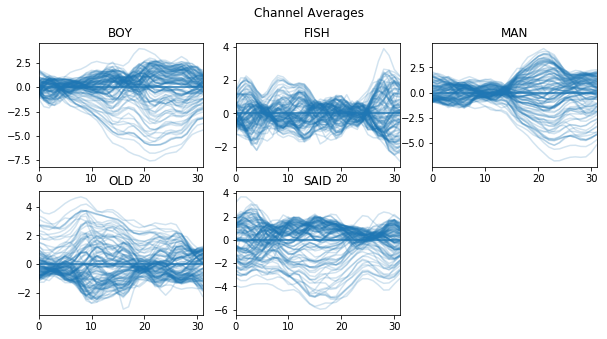

In [309]:
plt.figure(figsize=(10,5))
for n, la in enumerate(np.unique(labels)):
    plt.subplot(231 + n)
    sns.tsplot(samples[labels==la].mean(0).T, err_style='unit_traces' )
    plt.title(la)

plt.suptitle('Channel Averages');

At least there seem to be some differences between the features

In [341]:
# Reshaping X to fit the format of n_samples x n_features
X = samples.reshape(samples.shape[0], -1)
for ii in np.unique(runs):
    X[runs==ii, :] = StandardScaler().fit_transform(X[runs==ii, :])

## Simple data exploration

## Predictions
We are now trying to predict the word label using a simple cross-validation procedure.
Additions:
* Stratified KFold makes sure that each class appears approximately equally in each fold
* make_pipeline with StandardScaler scales the data for each fold and applies it to the test data.

In [344]:
LogR = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))
SKF = StratifiedKFold(n_splits=5)
trues, predictions = iu.wrap_cross_val_predict(LogR, X, labels, SKF)

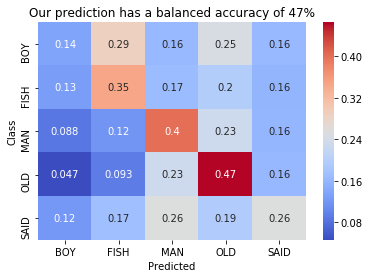

In [345]:
from sklearn.metrics import balanced_accuracy_score
iu.plot_confusion_matrix(np.hstack(trues), np.hstack(predictions), labels, normalize=True)
plt.xlabel('Predicted');
plt.ylabel('Class');
plt.title(f'Our prediction has a balanced accuracy of '
          + f'{balanced_accuracy_score(np.hstack(trues), np.hstack(labels)) * 100 :2.0f}%');

Prediction doesn't work to well (yet). Only for "FISH" and "MAN" are not confused constantly. The baseline prediction, however, is 0.2. Which is beaten by all classes except for "BOY". 
Let's try some different classifiers. 

In [346]:
LogR = make_pipeline(RobustScaler(), SVC(kernel='linear'))
SKF = StratifiedKFold(n_splits=5)
trues, predictions = iu.wrap_cross_val_predict(LogR, X, labels, SKF)

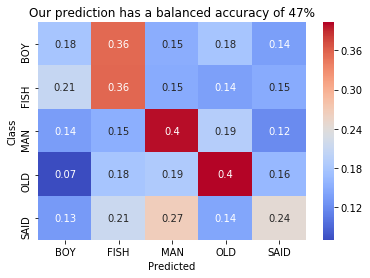

In [347]:
from sklearn.metrics import balanced_accuracy_score
iu.plot_confusion_matrix(np.hstack(trues), np.hstack(predictions), labels, normalize=True)
plt.xlabel('Predicted');
plt.ylabel('Class');
plt.title(f'Our prediction has a balanced accuracy of '
          + f'{balanced_accuracy_score(np.hstack(trues), np.hstack(labels)) * 100 :2.0f}%');